# GROUP 19
Dataset: IMDB Spoiler Dataset

Motivation:
User reviews are one of the first places people look when deciding whether to watch a movie or TV show but these reviews often contain spoilers that unintentionally ruin our viewing experience. Those spoilers may reveal key plot twists or endings, removing the suspense and emotional impact that make storytelling enjoyable. This is a significant problem for audiences who risk having our experiences diminished, and for review platforms which risk lower user trust and engagement. By building systems to automatically detect and filter spoilers, platforms can protect users from unwanted revelations while still allowing them to benefit from genuine reviews. The outcome would benefit casual viewers, streaming platforms and content creators alike, ensuring reviews remain helpful without spoiling the narrative.

## Load and Clean Dataset

In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
movie_details = []
movie_reviews = []

def load_dataset(filepath: str):
    dataset = []
    with open(filepath, "r") as f:
        for i, line in enumerate(f):
            line = line.strip()
            if line:
                data = json.loads(line)
                dataset.append(data)
    return dataset

def duration_to_minutes(duration):
    hour_match = re.search(r'(\d+)\s*h', duration)
    min_match = re.search(r'(\d+)\s*min', duration)

    hours = 0
    minutes = 0

    if hour_match:
        hours = int(hour_match.group(1))
    if min_match:
        minutes = int(min_match.group(1))
        
    return (hours * 60) + minutes

In [5]:
from ast import literal_eval
import ast
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("rmisra/imdb-spoiler-dataset")

print("Path to dataset files:", path)
print(os.listdir(path))
file_path = os.path.join(path, "IMDB_movie_details.json")
movie_details = pd.read_json(file_path, lines=True)

# movie_details = pd.DataFrame(load_dataset("IMDB_movie_details.json"))

movie_details['duration'] = movie_details['duration'].apply(duration_to_minutes)
movie_details['release_date'] = pd.to_datetime(movie_details['release_date'], errors='coerce')
movie_details['rating'] = pd.to_numeric(movie_details['rating'], errors='coerce')
movie_details['plot_synopsis'].replace("", np.nan, inplace=True)

movie_details.head()

Path to dataset files: /Users/garethyeo/.cache/kagglehub/datasets/rmisra/imdb-spoiler-dataset/versions/1
['IMDB_movie_details.json', 'IMDB_reviews.json']


,movie_id,plot_summary,duration,genre,rating,release_date,plot_synopsis
0,tt0105112,"Former CIA analyst, Jack Ryan is in England wi...",117,"[Action, Thriller]",6.9,1992-06-05,"Jack Ryan (Ford) is on a ""working vacation"" in..."
1,tt1204975,"Billy (Michael Douglas), Paddy (Robert De Niro...",105,[Comedy],6.6,2013-11-01,Four boys around the age of 10 are friends in ...
2,tt0243655,"The setting is Camp Firewood, the year 1981. I...",97,"[Comedy, Romance]",6.7,2002-04-11,NaN
3,tt0040897,"Fred C. Dobbs and Bob Curtin, both down on the...",126,"[Adventure, Drama, Western]",8.3,1948-01-24,Fred Dobbs (Humphrey Bogart) and Bob Curtin (T...
4,tt0126886,Tracy Flick is running unopposed for this year...,103,"[Comedy, Drama, Romance]",7.3,1999-05-07,Jim McAllister (Matthew Broderick) is a much-a...


In [6]:
# movie_reviews = pd.DataFrame(load_dataset("IMDB_reviews.json"))
file_path = os.path.join(path, "IMDB_reviews.json")
movie_reviews = pd.read_json(file_path, lines=True)

movie_reviews['review_date'] = pd.to_datetime(movie_reviews['review_date'], errors='coerce')
movie_reviews['is_spoiler'] = movie_reviews['is_spoiler'].astype(bool)
movie_reviews['rating'] = pd.to_numeric(movie_reviews['rating'], errors='coerce')
movie_reviews['review_id'] = np.arange(len(movie_reviews))

movie_reviews.head()

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary,review_id
0,2006-02-10,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.,0
1,2000-09-06,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.,1
2,2001-08-03,tt0111161,ur1285640,True,I believe that this film is the best story eve...,8,The best story ever told on film,2
3,2002-09-01,tt0111161,ur1003471,True,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?,3
4,2004-05-20,tt0111161,ur0226855,True,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted",4


In [7]:
train_data, test_data = train_test_split(
    movie_reviews,
    test_size=0.2,
    stratify=movie_reviews['is_spoiler'], 
    random_state=42
)

In [8]:
train_data.shape

(459130, 8)

In [9]:
test_data.shape

(114783, 8)

### Review's length Impact
The plot suggest that longer reviews are more spoiler-prone. Once reviews get past the very short range (0-999 words), spoiler likelihood sits above the overall baseline and generally increases with length. Short reviews tends to be non-spoiler because they’re brief and the dataset is skewed that way (imbalance). Long reviews show a strong spoiler tendency which is likely because they include plot summaries. However, but a few of those bins with long reviews has small number of reviews , so treat it with caution. 

Overall, we think that review length should be included as a supporting feature as it carries useful signal, especially the general “longer → riskier” trend.

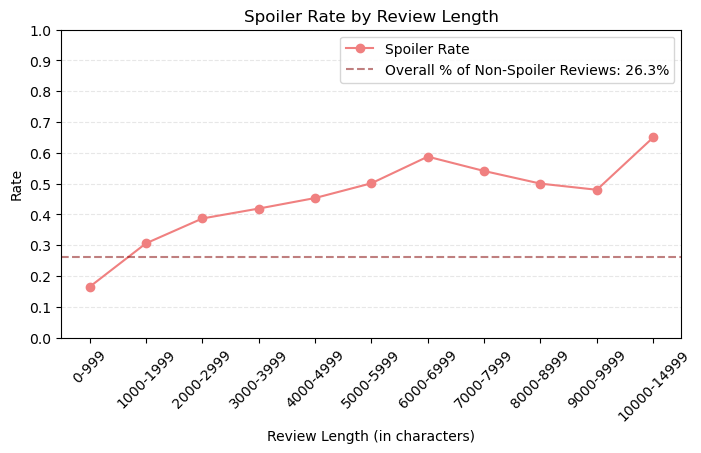

In [9]:
review_len_df = train_data[['review_text','is_spoiler']].copy()
review_len_df['review_length'] = train_data['review_text'].apply(lambda x: len(x))

review_len_df.sort_values('review_length',ascending=False).head(50)

bin_review_lengths = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 15000]
binned_review_lengths = pd.cut(
    review_len_df['review_length'],
    bins=bin_review_lengths,
    labels=[f"{bin_review_lengths[i]}-{bin_review_lengths[i+1]-1}" for i in range(len(bin_review_lengths)-1)],
    include_lowest=True,
    right=True
)
review_len_df["bin_review_length"] = binned_review_lengths

review_len_df = review_len_df.groupby('bin_review_length')['is_spoiler'].value_counts().unstack()

column_name = ['non_spoiler_rate', 'spoiler_rate']
review_len_df.columns = column_name

review_len_df['n_reviews'] = review_len_df['non_spoiler_rate'] + review_len_df['spoiler_rate']

review_len_df["non_spoiler_rate"] = review_len_df['non_spoiler_rate']/review_len_df['n_reviews']
review_len_df["spoiler_rate"] = review_len_df['spoiler_rate']/review_len_df['n_reviews']

# plot
fig, ax = plt.subplots(figsize=(8, 4))
line = ax.plot(review_len_df.index, review_len_df['spoiler_rate'], marker='o', color='lightcoral', label='Spoiler Rate')

ax.axhline(y = 0.263, xmin=0, xmax=20000, color='maroon', linestyle='dashed', alpha = 0.5, label='Overall % of Non-Spoiler Reviews: 26.3%')

ax.set_title("Spoiler Rate by Review Length")
ax.set_xlabel("Review Length (in characters)")
ax.set_ylabel("Rate")
ax.set_xticklabels(review_len_df.index, rotation=45)
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_ylim(0, 1)
ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.legend()
plt.show()  

In [10]:
review_len_df

,non_spoiler_rate,spoiler_rate,n_reviews
bin_review_length,,,
0-999,0.835271,0.164729,216294
1000-1999,0.693977,0.306023,143950
2000-2999,0.613195,0.386805,52021
3000-3999,0.581005,0.418995,24375
4000-4999,0.546793,0.453207,12566
5000-5999,0.498861,0.501139,9215
6000-6999,0.412389,0.587611,565
7000-7999,0.459016,0.540984,61
8000-8999,0.500000,0.500000,38


In [24]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
import numpy as np

class TfidfSvdScaler(BaseEstimator, TransformerMixin):
    def __init__(self,
                 max_features=50_000,
                 ngram_range=(1, 2),
                 min_df=3,
                 n_components=100,
                 random_state=42,
                 tfidf_dtype=np.float32):
        self.max_features = max_features
        self.ngram_range = ngram_range
        self.min_df = min_df
        self.n_components = n_components
        self.random_state = random_state
        self.tfidf_dtype = tfidf_dtype

        self._tfidf = None
        self._svd = None
        self._scaler = None

    def _to_list_of_str(self, X):
        if isinstance(X, np.ndarray):
            return [str(x) for x in X.tolist()]
        return [str(x) for x in X]

    def fit(self, X, y=None):
        X_list = self._to_list_of_str(X)

        self._tfidf = TfidfVectorizer(
            max_features=self.max_features,
            ngram_range=self.ngram_range,
            min_df=self.min_df,
            dtype=self.tfidf_dtype,    
        )
        X_tfidf = self._tfidf.fit_transform(X_list)  

        self._svd = TruncatedSVD(
            n_components=self.n_components,
            random_state=self.random_state
        )
        X_dense = self._svd.fit_transform(X_tfidf)  

        self._scaler = StandardScaler(with_mean=True)
        self._scaler.fit(X_dense)
        return self

    def transform(self, X):
        X_list = self._to_list_of_str(X)
        X_tfidf = self._tfidf.transform(X_list)
        X_dense = self._svd.transform(X_tfidf)
        X_scaled = self._scaler.transform(X_dense)
        return X_scaled


In [25]:
TEXT_COL   = "review_text"
TARGET_COL = "is_spoiler"
RANDOM_SEED = 42

import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    average_precision_score, precision_recall_curve,
    f1_score, precision_score, recall_score
)

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

X_train_text = train_data[TEXT_COL].astype(str).values
y_train      = train_data[TARGET_COL].astype(int).values

pre_dense = TfidfSvdScaler(
    max_features=50_000,   
    ngram_range=(1,2),
    min_df=5,             
    n_components=100,     
    random_state=RANDOM_SEED
)

base_clf = LogisticRegression(max_iter=1000, random_state=RANDOM_SEED)

pipe_none = ImbPipeline([
    ("pre", pre_dense),
    ("clf", base_clf)
])

pipe_cw = ImbPipeline([
    ("pre", pre_dense),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=RANDOM_SEED))
])

pipe_smote = ImbPipeline([
    ("sm", SMOTE(random_state=RANDOM_SEED)),
    ("clf", LogisticRegression(max_iter=1000, random_state=RANDOM_SEED))
])


#### Cross-validate the baselines (no-resample & class-weights)

In [26]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)
scoring = {
    "pr_auc": "average_precision",
    "f1": "f1",
    "precision": "precision",
    "recall": "recall",
}

def summarize_cv(label, cvres):
    return {
        "model": label,
        **{k.replace("test_", ""): (np.mean(v), np.std(v))
           for k, v in cvres.items() if k.startswith("test_")}
    }

cv_none = cross_validate(pipe_none, X_train_text, y_train, cv=cv, scoring=scoring, n_jobs=-1)
cv_cw   = cross_validate(pipe_cw,   X_train_text, y_train, cv=cv, scoring=scoring, n_jobs=-1)

summary_rows = [
    summarize_cv("No-resampling", cv_none),
    summarize_cv("Class-weights", cv_cw)
]

pd.DataFrame(summary_rows)


,model,pr_auc,f1,precision,recall
0,No-resampling,"(0.505856345190405, 0.0016875613908395764)","(0.34255921696020225, 0.003096339848154971)","(0.6124779921406476, 0.0016788191549739005)","(0.23778566686462885, 0.00304870089485637)"
1,Class-weights,"(0.5041714603103828, 0.0017595718989815556)","(0.5152201010577836, 0.0006412393929399745)","(0.42876095829538347, 0.000916626701030376)","(0.6453590061015101, 0.0010940485362876205)"


#### Tune SMOTE (grid search) and compare

In [27]:
pre_dense = TfidfSvdScaler(random_state=RANDOM_SEED)
X_train_dense = pre_dense.fit_transform(X_train_text)

param_grid = {
    "sm__sampling_strategy": [0.3, 0.5, 0.8, "auto"],
    "sm__k_neighbors": [3, 5]
}

grid = GridSearchCV(
    estimator=pipe_smote,
    param_grid=param_grid,
    scoring="average_precision",
    cv=cv,
    n_jobs=1
)
grid.fit(X_train_dense, y_train)

best_smote = grid.best_estimator_
best_params = grid.best_params_
best_score  = grid.best_score_

print("Best SMOTE params:", best_params)
print("Best SMOTE CV PR-AUC:", best_score)

summary_rows.append({"model": f"SMOTE {best_params}", "pr_auc": (best_score, np.nan)})
pd.DataFrame(summary_rows)


Best SMOTE params: {'sm__k_neighbors': 3, 'sm__sampling_strategy': 0.5}
Best SMOTE CV PR-AUC: 0.5005654346872418


,model,pr_auc,f1,precision,recall
0,No-resampling,"(0.505856345190405, 0.0016875613908395764)","(0.34255921696020225, 0.003096339848154971)","(0.6124779921406476, 0.0016788191549739005)","(0.23778566686462885, 0.00304870089485637)"
1,Class-weights,"(0.5041714603103828, 0.0017595718989815556)","(0.5152201010577836, 0.0006412393929399745)","(0.42876095829538347, 0.000916626701030376)","(0.6453590061015101, 0.0010940485362876205)"
2,"SMOTE {'sm__k_neighbors': 3, 'sm__sampling_str...","(0.5005654346872418, nan)",NaN,NaN,NaN


## SMOTE per bin based on the review length

In [30]:
# Compute review length
movie_reviews["review_length"] = movie_reviews[TEXT_COL].str.len()

# Bin review length into categories
movie_reviews["bin_review_length"] = pd.cut(
    movie_reviews["review_length"],
    bins=[0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 15000],
    labels=[
        "0-999", "1000-1999", "2000-2999", "3000-3999", "4000-4999",
        "5000-5999", "6000-6999", "7000-7999", "8000-8999", "9000-9999", "10000-14999"
    ],
    include_lowest=True
)

In [31]:
train_data, test_data = train_test_split(
    movie_reviews,
    test_size=0.2,
    stratify=movie_reviews['is_spoiler'], 
    random_state=42
)

In [32]:
train_data["bin_review_length"].value_counts().sort_index()


bin_review_length
0-999          216294
1000-1999      143950
2000-2999       52021
3000-3999       24375
4000-4999       12566
5000-5999        9215
6000-6999         565
7000-7999          61
8000-8999          38
9000-9999          25
10000-14999        20
Name: count, dtype: int64

In [33]:
pd.crosstab(train_data["bin_review_length"], train_data["is_spoiler"], normalize='index')


is_spoiler,False,True
bin_review_length,,
0-999,0.835271,0.164729
1000-1999,0.693977,0.306023
2000-2999,0.613195,0.386805
3000-3999,0.581005,0.418995
4000-4999,0.546793,0.453207
5000-5999,0.498861,0.501139
6000-6999,0.412389,0.587611
7000-7999,0.459016,0.540984
8000-8999,0.500000,0.500000


In [34]:
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd

def smote_per_bin(X, y, bins, sampling_strategy="auto", k_neighbors=3, random_state=None):
    """
    Applies SMOTE within each review-length bin separately.
    Returns concatenated resampled X and y.
    """
    smote = SMOTE(sampling_strategy=sampling_strategy, k_neighbors=k_neighbors, random_state=random_state)
    X_resampled_list, y_resampled_list = [], []

    unique_bins = np.unique(bins)
    print(f"Applying SMOTE per bin: {unique_bins}")

    for b in unique_bins:
        mask = bins == b
        X_b, y_b = X[mask], y[mask]
        
        # Skip bins that don't have both classes
        if len(np.unique(y_b)) < 2:
            print(f"Skipping bin {b}: only one class present.")
            X_resampled_list.append(X_b)
            y_resampled_list.append(y_b)
            continue
        
        try:
            X_res, y_res = smote.fit_resample(X_b, y_b)
            X_resampled_list.append(X_res)
            y_resampled_list.append(y_res)
            print(f"✔ Bin {b}: from {len(y_b)} to {len(y_res)} samples")
        except ValueError as e:
            print(f"⚠ Skipping bin {b} due to SMOTE error: {e}")
            X_resampled_list.append(X_b)
            y_resampled_list.append(y_b)

    X_all = np.vstack(X_resampled_list)
    y_all = np.concatenate(y_resampled_list)
    return X_all, y_all


In [48]:
# Separate features and labels
X_train_text = train_data[TEXT_COL]
y_train = train_data[TARGET_COL]

# TF-IDF + SVD (dense representation)
X_train_dense = pre_dense.fit_transform(X_train_text)

# Apply SMOTE *within each bin* (using the bin info from train_data)
X_train_bal, y_train_bal = smote_per_bin(
    X_train_dense,
    y_train.values,
    train_data["bin_review_length"].values,
    sampling_strategy="auto",
    k_neighbors=3,
    random_state=RANDOM_SEED
)

# Fit your grid search on the balanced data
grid.fit(X_train_bal, y_train_bal)


Applying SMOTE per bin: ['0-999' '1000-1999' '10000-14999' '2000-2999' '3000-3999' '4000-4999'
 '5000-5999' '6000-6999' '7000-7999' '8000-8999' '9000-9999']
✔ Bin 0-999: from 216294 to 361328 samples
✔ Bin 1000-1999: from 143950 to 199796 samples
✔ Bin 10000-14999: from 20 to 26 samples
✔ Bin 2000-2999: from 52021 to 63798 samples
✔ Bin 3000-3999: from 24375 to 28324 samples
✔ Bin 4000-4999: from 12566 to 13742 samples
✔ Bin 5000-5999: from 9215 to 9236 samples
✔ Bin 6000-6999: from 565 to 664 samples
✔ Bin 7000-7999: from 61 to 66 samples
✔ Bin 8000-8999: from 38 to 38 samples
✔ Bin 9000-9999: from 25 to 26 samples


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('sm', SMOTE(random_state=42)),
                                       ('clf',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42))]),
             n_jobs=1,
             param_grid={'sm__k_neighbors': [3, 5],
                         'sm__sampling_strategy': [0.3, 0.5, 0.8, 'auto']},
             scoring='average_precision')

#### Tune SMOTE (grid search)

In [39]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split, ParameterGrid
from sklearn.base import clone
from sklearn.metrics import f1_score
import numpy as np

def _allowed_k_values(y, k_values):
    classes, counts = np.unique(y, return_counts=True)
    if len(classes) < 2:
        return []
    minority_count = counts.min()
    return [k for k in k_values if isinstance(k, int) and 1 < k < minority_count]

def _choose_cv(y, desired_cv=3):
    classes, counts = np.unique(y, return_counts=True)
    if len(classes) < 2:
        return None
    m = counts.min()
    if m >= desired_cv: return desired_cv
    if m >= 2: return 2
    return None  # too small → use holdout

def _manual_holdout_search(X, y, clf, param_grid, scoring='f1', random_state=None, test_size=0.4):
    X_tr, X_va, y_tr, y_va = train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)
    best_score, best_params = -np.inf, None
    for params in ParameterGrid(param_grid):
        smote_kwargs = {k.replace('smote__',''): v for k, v in params.items() if k.startswith('smote__')}
        if 'k_neighbors' in smote_kwargs:
            if not _allowed_k_values(y_tr, [smote_kwargs['k_neighbors']]):
                continue
        pipe = Pipeline([
            ('smote', SMOTE(random_state=random_state, **smote_kwargs)),
            ('clf', clone(clf))
        ])
        try:
            pipe.fit(X_tr, y_tr)
            y_hat = pipe.predict(X_va)
            score = f1_score(y_va, y_hat, average='binary' if len(np.unique(y_va))==2 else 'macro')
        except Exception:
            continue
        if score > best_score:
            best_score, best_params = score, params
    return best_params, best_score

def smote_per_bin_tuned(
    X, y, bins, clf,
    param_grid=None,
    scoring='f1',
    cv=3,
    random_state=None,
    verbose=True
):
    """
    Tunes SMOTE inside each bin with a classifier, then resamples the full bin using best SMOTE.
    Returns concatenated resampled X, y and a per-bin report.
    """
    if param_grid is None:
        param_grid = {
            'smote__k_neighbors': [2, 3, 5],
            'smote__sampling_strategy': ['auto', 0.75, 1.0]
        }

    # ensure numpy arrays
    X_arr = np.asarray(X) if not hasattr(X, 'iloc') else X.values
    y_arr = np.asarray(y)
    b_arr = np.asarray(bins)

    X_out, y_out = [], []
    report = {}

    for b in np.unique(b_arr):
        mask = (b_arr == b)
        X_b, y_b = X_arr[mask], y_arr[mask]
        classes, counts = np.unique(y_b, return_counts=True)

        if len(classes) < 2:
            if verbose: print(f"[bin={b}] Only one class — skipping SMOTE.")
            X_out.append(X_b); y_out.append(y_b)
            report[b] = {'best_params': None, 'best_score': None, 'cv_used': None, 'minority_count': int(counts.min())}
            continue

        # filter k_neighbors that are feasible given minority size
        grid = dict(param_grid)
        if 'smote__k_neighbors' in grid:
            feasible_ks = _allowed_k_values(y_b, grid['smote__k_neighbors'])
            if not feasible_ks:
                # last-resort k based on size
                minority_count = counts.min()
                feasible_ks = [2] if minority_count > 2 else [max(2, minority_count - 1)]
            grid['smote__k_neighbors'] = feasible_ks

        # choose CV or fallback to holdout
        cv_used = _choose_cv(y_b, desired_cv=cv)
        if cv_used is None:
            best_params, best_score = _manual_holdout_search(X_b, y_b, clf, grid, scoring=scoring, random_state=random_state)
        else:
            pipe = Pipeline([('smote', SMOTE(random_state=random_state)), ('clf', clone(clf))])
            kfold = StratifiedKFold(n_splits=cv_used, shuffle=True, random_state=random_state)
            gs = GridSearchCV(pipe, grid, scoring=scoring, cv=kfold, n_jobs=1, error_score='raise')
            try:
                gs.fit(X_b, y_b)
                best_params, best_score = gs.best_params_, gs.best_score_
            except Exception as e:
                if verbose: print(f"[bin={b}] CV failed ({e}). Using holdout.")
                best_params, best_score = _manual_holdout_search(X_b, y_b, clf, grid, scoring=scoring, random_state=random_state)

        report[b] = {
            'best_params': best_params,
            'best_score': best_score,
            'cv_used': cv_used,
        }

        # resample the FULL bin using the chosen SMOTE params
        if best_params is None:
            # fallback: try a safe k
            ks = _allowed_k_values(y_b, [5,3,2])
            smote_kwargs = {'k_neighbors': (ks[0] if ks else 2), 'random_state': random_state}
        else:
            smote_kwargs = {k.replace('smote__',''): v for k, v in best_params.items() if k.startswith('smote__')}
            smote_kwargs['random_state'] = random_state

        try:
            X_res_b, y_res_b = SMOTE(**smote_kwargs).fit_resample(X_b, y_b)
            X_out.append(X_res_b); y_out.append(y_res_b)
        except Exception as e:
            if verbose: print(f"[bin={b}] Final resample failed ({e}). Keeping original bin.")
            X_out.append(X_b); y_out.append(y_b)

    return np.vstack(X_out), np.concatenate(y_out), report


In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from collections import Counter
import pandas as pd
import numpy as np

X_train_text = train_data[TEXT_COL].astype(str)
y_train = train_data[TARGET_COL].values

X_test_text  = test_data[TEXT_COL].astype(str)
y_test       = test_data[TARGET_COL].values

X_train_dense = pre_dense.fit_transform(X_train_text)
X_test_dense  = pre_dense.transform(X_test_text)

bins_train = train_data["bin_review_length"].astype(object).fillna("unbinned").values

clf_for_tuning = LogisticRegression(max_iter=1000, solver="liblinear", random_state=RANDOM_SEED)

smote_param_grid = {
    "smote__k_neighbors": [2, 3, 5, 7],
    "smote__sampling_strategy": ["auto", 0.5, 0.75, 1.0],
}

X_train_bal, y_train_bal, per_bin_report = smote_per_bin_tuned(
    X=X_train_dense,
    y=y_train,
    bins=bins_train,
    clf=clf_for_tuning,
    param_grid=smote_param_grid,
    scoring="f1",        
    cv=3,               
    random_state=RANDOM_SEED,
    verbose=False
)

print("Class balance (original):", Counter(y_train))
print("Class balance (balanced):", Counter(y_train_bal))

per_bin_df = pd.DataFrame.from_dict(per_bin_report, orient="index").reset_index()
per_bin_df.columns = ["bin", "best_params", "best_score", "cv_used"]
try:
    display(per_bin_df)
except NameError:
    print(per_bin_df)

grid.fit(X_train_bal, y_train_bal)

print("Grid best score (CV on balanced data):", getattr(grid, "best_score_", None))
print("Grid best params:", getattr(grid, "best_params_", None))

y_pred = grid.predict(X_test_dense)
print("\nClassification report (test):")
print(classification_report(y_test, y_pred))

if hasattr(grid, "predict_proba"):
    try:
        y_proba = grid.predict_proba(X_test_dense)[:, 1]
        print("ROC-AUC (test):", round(roc_auc_score(y_test, y_proba), 4))
    except Exception:
        pass


Class balance (original): Counter({False: 338391, True: 120739})
Class balance (balanced): Counter({False: 338439, True: 293356})


,bin,best_params,best_score,cv_used
0,0-999,"{'smote__k_neighbors': 2, 'smote__sampling_str...",0.355324,3
1,1000-1999,"{'smote__k_neighbors': 7, 'smote__sampling_str...",0.497845,3
2,10000-14999,"{'smote__k_neighbors': 2, 'smote__sampling_str...",0.909091,3
3,2000-2999,"{'smote__k_neighbors': 5, 'smote__sampling_str...",0.573650,3
4,3000-3999,"{'smote__k_neighbors': 2, 'smote__sampling_str...",0.590463,3
5,4000-4999,"{'smote__k_neighbors': 3, 'smote__sampling_str...",0.631259,3
6,5000-5999,"{'smote__k_neighbors': 5, 'smote__sampling_str...",0.650750,3
7,6000-6999,"{'smote__k_neighbors': 7, 'smote__sampling_str...",0.704981,3
8,7000-7999,"{'smote__k_neighbors': 2, 'smote__sampling_str...",0.645161,3
9,8000-8999,"{'smote__k_neighbors': 2, 'smote__sampling_str...",0.153846,3


Grid best score (CV on balanced data): 0.6700792083194974
Grid best params: {'sm__k_neighbors': 5, 'sm__sampling_strategy': 'auto'}

Classification report (test):
              precision    recall  f1-score   support

       False       0.83      0.67      0.74     84598
        True       0.39      0.61      0.48     30185

    accuracy                           0.65    114783
   macro avg       0.61      0.64      0.61    114783
weighted avg       0.71      0.65      0.67    114783

ROC-AUC (test): 0.6862


(Melisa)

In [50]:
train_data_oversample = train_data.copy()

In [51]:
train_data_oversample.head()

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary,review_id
94625,2012-10-25,tt0033870,ur5291991,True,The Maltese Falcon film noir based on the nove...,10,A Classic Detective Thriller,94625
89585,2015-05-29,tt1392190,ur48053412,True,Water is a scarce resource so when it is dispe...,1,No plot spoilers,89585
187840,2014-02-26,tt1800241,ur28438054,True,I was really expecting a lot given all the hyp...,5,Most overrated film of 2013,187840
265694,2017-09-11,tt1396484,ur35553121,False,"This movie was just awful. It was not scary, t...",1,Waste of oxygen,265694
125407,2011-01-06,tt0840361,ur14069613,False,"""The Town"" is an excellent film that does have...",7,Entertaining Heist Film,125407


Data Prep

In [52]:
train_data_oversample['review_length'] = train_data_oversample['review_text'].apply(lambda x: len(x))

train_data_oversample.sort_values('review_length',ascending=False).head(50)

bin_review_lengths = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 15000]
binned_review_lengths = pd.cut(
    train_data_oversample['review_length'],
    bins=bin_review_lengths,
    labels=[f"{bin_review_lengths[i]}-{bin_review_lengths[i+1]-1}" for i in range(len(bin_review_lengths)-1)],
    include_lowest=True,
    right=True
)
train_data_oversample["bin_review_length"] = binned_review_lengths

train_data_oversample.head()

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary,review_id,review_length,bin_review_length
94625,2012-10-25,tt0033870,ur5291991,True,The Maltese Falcon film noir based on the nove...,10,A Classic Detective Thriller,94625,2609,2000-2999
89585,2015-05-29,tt1392190,ur48053412,True,Water is a scarce resource so when it is dispe...,1,No plot spoilers,89585,1417,1000-1999
187840,2014-02-26,tt1800241,ur28438054,True,I was really expecting a lot given all the hyp...,5,Most overrated film of 2013,187840,1314,1000-1999
265694,2017-09-11,tt1396484,ur35553121,False,"This movie was just awful. It was not scary, t...",1,Waste of oxygen,265694,364,0-999
125407,2011-01-06,tt0840361,ur14069613,False,"""The Town"" is an excellent film that does have...",7,Entertaining Heist Film,125407,2256,2000-2999


Pros: spoiler vs. non-spoiler balanced
Cons: Each length bin does not have the same number of data. Also, since the ratio of spoiler vs. non-spoiler are now 1:1, I think it will disturb the assumption of review_length vs. is_spoiler correlation.

In [ ]:
import pandas as pd
from sklearn.utils import resample

def oversample_reviews(df):
    resampled_data = []
    
    for bin_label in df['bin_review_length'].unique():
        bin_data = df[df['bin_review_length'] == bin_label]
        
        # Separate the data into spoiler and non-spoiler classes
        spoiler_data = bin_data[bin_data['is_spoiler'] == 1]
        non_spoiler_data = bin_data[bin_data['is_spoiler'] == 0]
        
        # Perform oversampling based on class imbalance in each bin
        if len(spoiler_data) < len(non_spoiler_data):
            # Oversample the spoiler class
            oversample_spoiler = resample(spoiler_data, 
                                          replace=True,
                                          n_samples=len(non_spoiler_data) - len(spoiler_data),
                                          random_state=42)
            bin_data = pd.concat([bin_data, oversample_spoiler])
        elif len(non_spoiler_data) < len(spoiler_data):
            # Oversample the non-spoiler class
            oversample_non_spoiler = resample(non_spoiler_data, 
                                              replace=True, 
                                              n_samples=len(spoiler_data) - len(non_spoiler_data),
                                              random_state=42)
            bin_data = pd.concat([bin_data, oversample_non_spoiler])
        # If both classes are already balanced, do nothing (skip resampling)

        resampled_data.append(bin_data)
    
    df_resampled = pd.concat(resampled_data)
    df_resampled = df_resampled.reset_index(drop=True)
    df_resampled = df_resampled.sample(frac=1, random_state=42).reset_index(drop=True)
    
    return df_resampled

df_oversampled_by_class# Apply the oversampling function to the DataFrame
 = oversample_reviews(train_data_oversample)

# Oversample by class check
df_oversampled_by_class_info = df_oversampled_by_class.groupby('bin_review_length')['is_spoiler'].value_counts().unstack(fill_value=0)
column_name = ['non_spoiler_rate', 'spoiler_rate']
df_oversampled_by_class_info.columns = column_name
df_oversampled_by_class_info['n_reviews'] = df_oversampled_by_class_info['non_spoiler_rate'] + df_oversampled_by_class_info['spoiler_rate']
df_oversampled_by_class_info["non_spoiler_rate"] = df_oversampled_by_class_info['non_spoiler_rate'] / df_oversampled_by_class_info['n_reviews']
df_oversampled_by_class_info["spoiler_rate"] = df_oversampled_by_class_info['spoiler_rate'] / df_oversampled_by_class_info['n_reviews']

df_oversampled_by_class_info


,non_spoiler_rate,spoiler_rate,n_reviews
bin_review_length,,,
0-999,0.5,0.5,361328
1000-1999,0.5,0.5,199796
2000-2999,0.5,0.5,63798
3000-3999,0.5,0.5,28324
4000-4999,0.5,0.5,13742
5000-5999,0.5,0.5,9236
6000-6999,0.5,0.5,664
7000-7999,0.5,0.5,66
8000-8999,0.5,0.5,38


Pros: the 'correlation' (if there's any) will be mantained
Cons: we have a vvvv large dataset

In [ ]:
import pandas as pd
from sklearn.utils import resample

def oversample_bins_to_equal(df):
    resampled_data = []
    
    largest_bin_size = df.groupby('bin_review_length').size().max()
    
    for bin_label in df['bin_review_length'].unique():
        bin_data = df[df['bin_review_length'] == bin_label]
        
        samples_needed = largest_bin_size - len(bin_data)
        
        if samples_needed > 0:
            # Oversample
            oversampled_bin = resample(bin_data, 
                                       replace=True,
                                       n_samples=samples_needed,
                                       random_state=42)
            
            bin_data = pd.concat([bin_data, oversampled_bin])
        
        resampled_data.append(bin_data)
    
    df_resampled = pd.concat(resampled_data)
    df_resampled = df_resampled.reset_index(drop=True)
    df_resampled = df_resampled.sample(frac=1, random_state=42).reset_index(drop=True)
    
    return df_resampled

# Apply the oversampling function to the DataFrame
df_oversampled_by_bin = oversample_bins_to_equal(train_data_oversample)

# Oversample by bin check
df_oversampled_by_bin_info = df_oversampled_by_bin.groupby('bin_review_length')['is_spoiler'].value_counts().unstack(fill_value=0)
column_name = ['non_spoiler_rate', 'spoiler_rate']
df_oversampled_by_bin_info.columns = column_name
df_oversampled_by_bin_info['n_reviews'] = df_oversampled_by_bin_info['non_spoiler_rate'] + df_oversampled_by_bin_info['spoiler_rate']
df_oversampled_by_bin_info["non_spoiler_rate"] = df_oversampled_by_bin_info['non_spoiler_rate'] / df_oversampled_by_bin_info['n_reviews']
df_oversampled_by_bin_info["spoiler_rate"] = df_oversampled_by_bin_info['spoiler_rate'] / df_oversampled_by_bin_info['n_reviews']

df_oversampled_by_bin_info


# UNDERSAMPLING (BASED ON REVIEW LENGTH)

In [10]:
# movie_reviews = pd.DataFrame(load_dataset("/Users/catherinekang/Documents/CS3244/project/data/IMDB_reviews.json"))
file_path = os.path.join(path, "IMDB_reviews.json")
movie_reviews = pd.read_json(file_path, lines=True)


movie_reviews['review_date'] = pd.to_datetime(movie_reviews['review_date'], errors='coerce')
movie_reviews['is_spoiler'] = movie_reviews['is_spoiler'].astype(bool)
movie_reviews['rating'] = pd.to_numeric(movie_reviews['rating'], errors='coerce')
movie_reviews['review_id'] = np.arange(len(movie_reviews))

movie_reviews.head()
import pandas as pd
import numpy as np
from sklearn.utils import resample, shuffle

def random_undersample(df: pd.DataFrame,
                       target_col: str,
                       target_ratio: float = 1.0,
                       majority_class=None,
                       random_state: int = 42) -> pd.DataFrame:

    # current distribution
    counts = df[target_col].value_counts(dropna=False)
    if len(counts) < 2:
        raise ValueError("Target column must have at least two classes.")
    # auto-detect classes
    maj_label = majority_class if majority_class is not None else counts.idxmax()
    min_label = counts.idxmin()

    n_min = int(counts[min_label])
    n_maj_new = max(1, int(round(n_min * target_ratio)))

    df_min = df[df[target_col] == min_label]
    df_maj = df[df[target_col] == maj_label]

   
    if len(df_maj) <= n_maj_new:
        out = pd.concat([df_min, df_maj], axis=0)
        return shuffle(out, random_state=random_state).reset_index(drop=True)

    df_maj_down = resample(
        df_maj,
        replace=False,
        n_samples=n_maj_new,
        random_state=random_state
    )

    out = pd.concat([df_min, df_maj_down], axis=0)
    out = shuffle(out, random_state=random_state).reset_index(drop=True)
    return out

print("Before undersampling:")
print(movie_reviews["is_spoiler"].value_counts())

# Balance to 1:1
reviews_balanced = random_undersample(
    movie_reviews,
    target_col="is_spoiler",
    target_ratio=1.0,   
    random_state=42
)

print("\nAfter undersampling:")
print(reviews_balanced["is_spoiler"].value_counts())

from sklearn.model_selection import train_test_split

X = reviews_balanced["review_text"]     
y = reviews_balanced["is_spoiler"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("\nTrain/Val shapes:", X_train.shape, X_val.shape)
print("Train class balance:\n", y_train.value_counts())
print("Val class balance:\n", y_val.value_counts())


Before undersampling:
is_spoiler
False    422989
True     150924
Name: count, dtype: int64

After undersampling:
is_spoiler
True     150924
False    150924
Name: count, dtype: int64

Train/Val shapes: (241478,) (60370,)
Train class balance:
 is_spoiler
False    120739
True     120739
Name: count, dtype: int64
Val class balance:
 is_spoiler
False    30185
True     30185
Name: count, dtype: int64


In [14]:
import numpy as np
from tqdm import trange

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

# Ensure we have Python lists
X_train_texts = X_train.tolist()
X_val_texts   = X_val.tolist()
y_train_arr   = np.array(y_train, dtype=int)
y_val_arr     = np.array(y_val, dtype=int)

def print_results(y_true, y_pred, title="Results"):
    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    print(f"\n=== {title} ===")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {p:.4f}")
    print(f"Recall:    {r:.4f}")
    print(f"F1:        {f1:.4f}")


In [18]:
#BERT and Logistic Regression

In [13]:
from transformers import BertTokenizer, BertModel
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer_bert = BertTokenizer.from_pretrained("bert-base-uncased")
model_bert = BertModel.from_pretrained("bert-base-uncased").to(device)
model_bert.eval()

def mean_pool(last_hidden_state, attention_mask):
    # last_hidden_state: [B, T, H], attention_mask: [B, T]
    mask = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
    masked = last_hidden_state * mask
    summed = masked.sum(dim=1)
    counts = mask.sum(dim=1).clamp(min=1e-9)
    return summed / counts

@torch.no_grad()
def embed_with_bert(texts, batch_size=32, max_len=256):
    embs = []
    for i in trange(0, len(texts), batch_size, desc="BERT embedding"):
        batch = texts[i:i+batch_size]
        enc = tokenizer_bert(
            batch, padding=True, truncation=True, max_length=max_len, return_tensors="pt"
        ).to(device)
        out = model_bert(**enc)
        pooled = mean_pool(out.last_hidden_state, enc["attention_mask"])  # [B, 768]
        embs.append(pooled.cpu().numpy())
    return np.vstack(embs)

Xtr_bert = embed_with_bert(X_train_texts, batch_size=32, max_len=256)
Xva_bert = embed_with_bert(X_val_texts,   batch_size=32, max_len=256)

clf_bert = LogisticRegression(max_iter=2000, n_jobs=-1)
clf_bert.fit(Xtr_bert, y_train_arr)

yva_pred_bert = clf_bert.predict(Xva_bert)
print_results(y_val_arr, yva_pred_bert, title="BERT + Logistic Regression")


BERT embedding:   0%|                        | 4/7547 [00:07<4:10:08,  1.99s/it]


KeyboardInterrupt: 

In [ ]:
#BERT and Logistic Regression Optimized

BERT embedding:   5%|█                     | 348/7547 [11:50<5:05:44,  2.55s/it]

In [15]:
import numpy as np, torch, time
from transformers import AutoTokenizer, AutoModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm import tqdm  # <- progress bar

# --- Configs ---
BERT_MODEL = "bert-base-uncased"   # try "distilbert-base-uncased" for faster runs
MAX_LEN = 128
BATCH_SIZE = 64

device = torch.device(
    "cuda" if torch.cuda.is_available()
    else ("mps" if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available() else "cpu")
)
print("Device:", device)

tok = AutoTokenizer.from_pretrained(BERT_MODEL, use_fast=True)
mdl = AutoModel.from_pretrained(BERT_MODEL).to(device)
mdl.eval()

def _mean_pool(hidden_states, attention_mask):
    mask = attention_mask.unsqueeze(-1).float()
    summed = (hidden_states * mask).sum(1)
    counts = mask.sum(1).clamp(min=1e-9)
    return summed / counts

@torch.no_grad()
def embed_texts_bert(texts, batch_size=BATCH_SIZE, max_len=MAX_LEN):
    """Embed a list of texts using (Distil)BERT, with progress bar."""
    all_vecs = []
    use_amp = device.type == "cuda"
    start = time.time()
    for i in tqdm(range(0, len(texts), batch_size), desc=f"Embedding {BERT_MODEL}", unit="batch"):
        batch = texts[i:i+batch_size]
        enc = tok(batch, padding=True, truncation=True, max_length=max_len, return_tensors="pt").to(device)
        if use_amp:
            from torch.cuda.amp import autocast
            with autocast():
                h = mdl(**enc).last_hidden_state
        else:
            h = mdl(**enc).last_hidden_state
        pooled = _mean_pool(h, enc["attention_mask"]).cpu().numpy()
        all_vecs.append(pooled)
    arr = np.vstack(all_vecs)
    print(f"\n✅ Embedded {len(texts)} texts in {time.time()-start:.1f}s (bs={batch_size}, max_len={max_len})")
    return arr

# --- Make sure you have your splits ---
X_train_texts = X_train.tolist()
X_val_texts   = X_val.tolist()
y_train_arr   = np.asarray(y_train, dtype=int)
y_val_arr     = np.asarray(y_val, dtype=int)

# --- Generate embeddings with progress display ---
Xtr_bert = embed_texts_bert(X_train_texts)
Xva_bert = embed_texts_bert(X_val_texts)

# --- Train & evaluate Logistic Regression ---
clf_bert = LogisticRegression(max_iter=2000, n_jobs=-1)
clf_bert.fit(Xtr_bert, y_train_arr)
yva_pred_bert = clf_bert.predict(Xva_bert)

acc = accuracy_score(y_val_arr, yva_pred_bert)
p, r, f1, _ = precision_recall_fscore_support(y_val_arr, yva_pred_bert, average="binary", zero_division=0)
print(f"\n[BERT] Acc={acc:.4f}  Prec={p:.4f}  Recall={r:.4f}  F1={f1:.4f}")


Device: mps


Embedding bert-base-uncased: 100%|███████| 3774/3774 [48:09<00:00,  1.31batch/s]



✅ Embedded 241478 texts in 2892.6s (bs=64, max_len=128)


Embedding bert-base-uncased: 100%|█████████| 944/944 [10:12<00:00,  1.54batch/s]



✅ Embedded 60370 texts in 612.3s (bs=64, max_len=128)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


[BERT] Acc=0.6426  Prec=0.6419  Recall=0.6448  F1=0.6434


In [ ]:
#SBERT and Logistic Regression

In [16]:
# ====== Sentence-BERT (optimized with progress + timing) ======
import numpy as np, torch, time
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm import tqdm  # progress bar

# --- Configuration ---
SBERT_MODEL = "all-MiniLM-L6-v2"  # 384-dim, small & fast
SBERT_BATCH = 256                 # adjust if VRAM limited (try 128 if OOM)

device_str = (
    "cuda" if torch.cuda.is_available()
    else ("mps" if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available() else "cpu")
)
print(f"Using device: {device_str}")

# --- Load SBERT ---
sbert = SentenceTransformer(SBERT_MODEL, device=device_str)

# --- Function with progress tracking ---
def embed_with_progress(model, texts, batch_size):
    """Encode texts with tqdm progress and time tracking."""
    start = time.time()
    all_embs = []
    total_batches = (len(texts) + batch_size - 1) // batch_size

    for i in tqdm(range(0, len(texts), batch_size), desc="Encoding SBERT", unit="batch"):
        batch = texts[i:i+batch_size]
        embs = model.encode(batch, convert_to_numpy=True, normalize_embeddings=False, show_progress_bar=False)
        all_embs.append(embs)

    arr = np.vstack(all_embs)
    elapsed = time.time() - start
    print(f"✅ Encoded {len(texts)} texts in {elapsed:.1f}s "
          f"({len(texts)/elapsed:.1f} texts/sec, bs={batch_size})")
    return arr

# --- Prepare data ---
X_train_texts = X_train.tolist()
X_val_texts   = X_val.tolist()
y_train_arr   = np.asarray(y_train, dtype=int)
y_val_arr     = np.asarray(y_val, dtype=int)

# --- Generate embeddings with progress ---
Xtr_sbert = embed_with_progress(sbert, X_train_texts, SBERT_BATCH)
Xva_sbert = embed_with_progress(sbert, X_val_texts, SBERT_BATCH)

# --- Train & evaluate Logistic Regression ---
clf_sbert = LogisticRegression(max_iter=2000, n_jobs=-1)
clf_sbert.fit(Xtr_sbert, y_train_arr)
yva_pred_sbert = clf_sbert.predict(Xva_sbert)

acc = accuracy_score(y_val_arr, yva_pred_sbert)
p, r, f1, _ = precision_recall_fscore_support(y_val_arr, yva_pred_sbert, average="binary", zero_division=0)
print(f"\n[SBERT] Acc={acc:.4f}  Prec={p:.4f}  Recall={r:.4f}  F1={f1:.4f}")


Using device: mps


Encoding SBERT: 100%|██████████████████████| 944/944 [18:50<00:00,  1.20s/batch]


✅ Encoded 241478 texts in 1130.3s (213.6 texts/sec, bs=256)


Encoding SBERT: 100%|██████████████████████| 236/236 [04:40<00:00,  1.19s/batch]


✅ Encoded 60370 texts in 280.5s (215.3 texts/sec, bs=256)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avo


[SBERT] Acc=0.6628  Prec=0.6598  Recall=0.6721  F1=0.6659


In [17]:
import numpy as np

# For BERT embeddings
np.save("Xtr_bert.npy", Xtr_bert)
np.save("Xva_bert.npy", Xva_bert)

# For SBERT embeddings
np.save("Xtr_sbert.npy", Xtr_sbert)
np.save("Xva_sbert.npy", Xva_sbert)



EVALUATION METRICS (using your variables)
Accuracy:                   0.6628
Recall (Primary Metric):    0.6721
Precision:                  0.6598
F1-Score:                   0.6659
ROC-AUC:                    0.7263

Detailed Classification Report:
              precision    recall  f1-score   support

  No Spoiler       0.67      0.65      0.66     30185
     Spoiler       0.66      0.67      0.67     30185

    accuracy                           0.66     60370
   macro avg       0.66      0.66      0.66     60370
weighted avg       0.66      0.66      0.66     60370



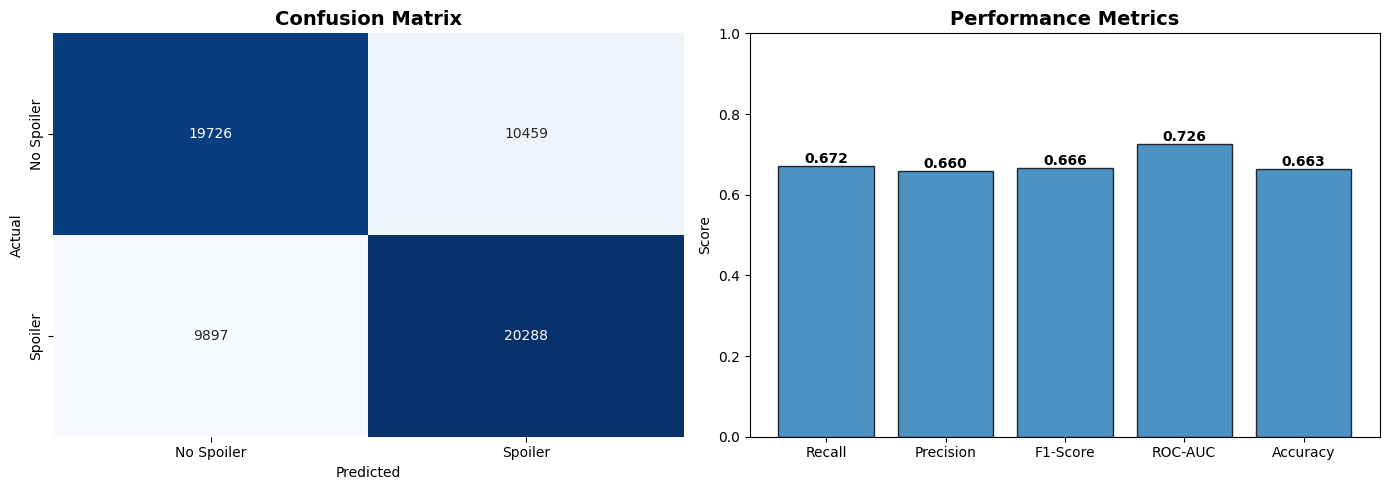

In [30]:
# ===== Display results in your Step 5/6 format using your variables =====
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    recall_score, precision_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, accuracy_score
)

# 1) Get probabilities from your trained classifier
yva_proba_sbert = clf_sbert.predict_proba(Xva_sbert)[:, 1]

# 2) Compute metrics
recall    = recall_score(y_val_arr, yva_pred_sbert)
precision = precision_score(y_val_arr, yva_pred_sbert)
f1        = f1_score(y_val_arr, yva_pred_sbert)
roc_auc   = roc_auc_score(y_val_arr, yva_proba_sbert)
acc       = accuracy_score(y_val_arr, yva_pred_sbert)

print("\n" + "="*60)
print("EVALUATION METRICS (using your variables)")
print("="*60)
print(f"Accuracy:                   {acc:.4f}")
print(f"Recall (Primary Metric):    {recall:.4f}")
print(f"Precision:                  {precision:.4f}")
print(f"F1-Score:                   {f1:.4f}")
print(f"ROC-AUC:                    {roc_auc:.4f}")
print("="*60)

print("\nDetailed Classification Report:")
print(classification_report(y_val_arr, yva_pred_sbert, target_names=['No Spoiler', 'Spoiler']))

# 3) Visualize (confusion matrix + metrics bar chart)
cm = confusion_matrix(y_val_arr, yva_pred_sbert)

plt.figure(figsize=(14, 5))

# Confusion Matrix
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Spoiler', 'Spoiler'],
            yticklabels=['No Spoiler', 'Spoiler'])
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Metrics Bars
plt.subplot(1, 2, 2)
metrics = ['Recall', 'Precision', 'F1-Score', 'ROC-AUC', 'Accuracy']
values  = [recall, precision, f1, roc_auc, acc]
bars = plt.bar(metrics, values, alpha=0.8, edgecolor='black')
plt.ylim(0, 1)
plt.title('Performance Metrics', fontsize=14, fontweight='bold')
plt.ylabel('Score')

for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2., value,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()
acc_sbert, precision_sbert, recall_sbert, f1_sbert, roc_auc_sbert = acc, precision, recall, f1, roc_auc


EVALUATION METRICS — BERT + Logistic Regression
Accuracy:                   0.6426
Recall (Primary Metric):    0.6448
Precision:                  0.6419
F1-Score:                   0.6434
ROC-AUC:                    0.7021

Detailed Classification Report:
              precision    recall  f1-score   support

  No Spoiler       0.64      0.64      0.64     30185
     Spoiler       0.64      0.64      0.64     30185

    accuracy                           0.64     60370
   macro avg       0.64      0.64      0.64     60370
weighted avg       0.64      0.64      0.64     60370



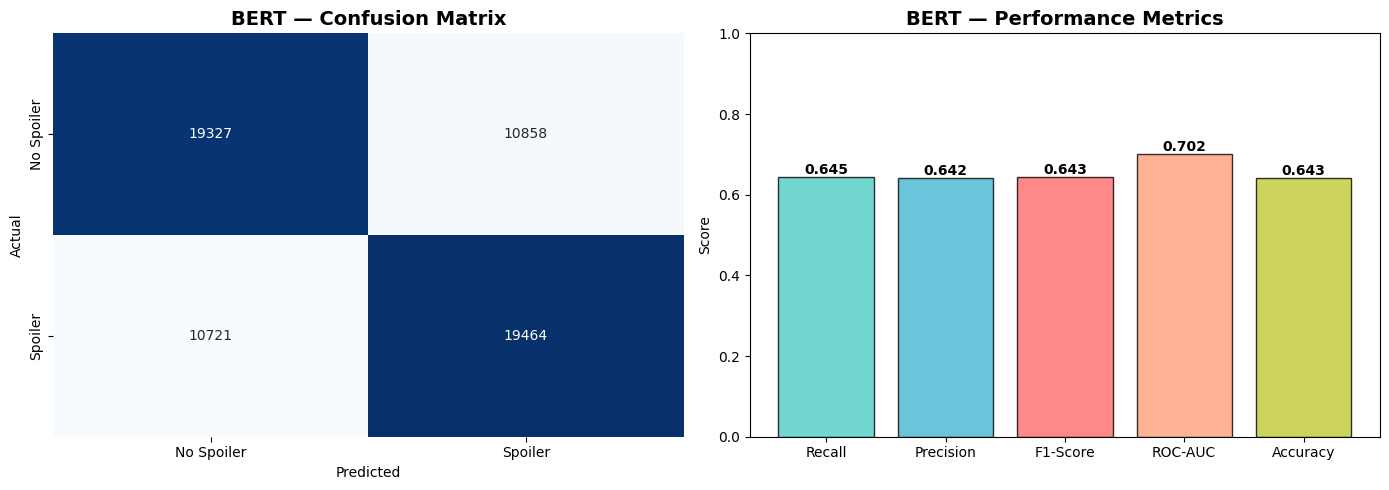

In [29]:
# ===== Display results in Step 5/6 format for BERT =====
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    recall_score, precision_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, accuracy_score
)

# 1) Get probabilities from your trained classifier
yva_proba_bert = clf_bert.predict_proba(Xva_bert)[:, 1]

# 2) Compute metrics
recall    = recall_score(y_val_arr, yva_pred_bert)
precision = precision_score(y_val_arr, yva_pred_bert)
f1        = f1_score(y_val_arr, yva_pred_bert)
roc_auc   = roc_auc_score(y_val_arr, yva_proba_bert)
acc       = accuracy_score(y_val_arr, yva_pred_bert)

print("\n" + "="*60)
print("EVALUATION METRICS — BERT + Logistic Regression")
print("="*60)
print(f"Accuracy:                   {acc:.4f}")
print(f"Recall (Primary Metric):    {recall:.4f}")
print(f"Precision:                  {precision:.4f}")
print(f"F1-Score:                   {f1:.4f}")
print(f"ROC-AUC:                    {roc_auc:.4f}")
print("="*60)

print("\nDetailed Classification Report:")
print(classification_report(y_val_arr, yva_pred_bert, target_names=['No Spoiler', 'Spoiler']))

# 3) Visualize results (confusion matrix + metrics bar chart)
cm = confusion_matrix(y_val_arr, yva_pred_bert)

plt.figure(figsize=(14, 5))

# Confusion Matrix
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Spoiler', 'Spoiler'],
            yticklabels=['No Spoiler', 'Spoiler'])
plt.title('BERT — Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Metrics Bars
plt.subplot(1, 2, 2)
metrics = ['Recall', 'Precision', 'F1-Score', 'ROC-AUC', 'Accuracy']
values  = [recall, precision, f1, roc_auc, acc]
bars = plt.bar(metrics, values, alpha=0.8, edgecolor='black', color=['#4ECDC4', '#45B7D1', '#FF6B6B', '#FFA07A', '#C0CA33'])
plt.ylim(0, 1)
plt.title('BERT — Performance Metrics', fontsize=14, fontweight='bold')
plt.ylabel('Score')

for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2., value,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()
acc_bert, precision_bert, recall_bert, f1_bert, roc_auc_bert = acc, precision, recall, f1, roc_auc


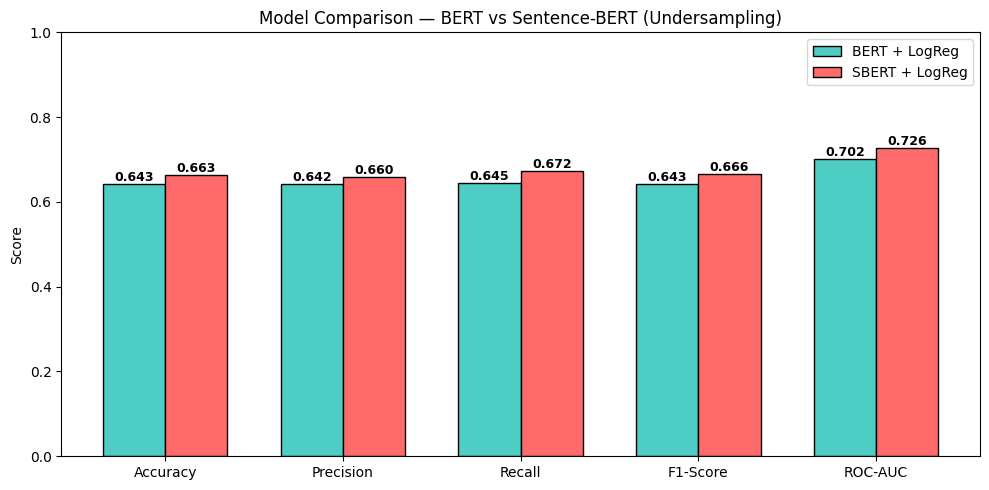

In [31]:
# ===== Side-by-side comparison: BERT vs SBERT =====
import numpy as np
import matplotlib.pyplot as plt

labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

bert_scores  = [acc_bert, precision_bert, recall_bert, f1_bert, roc_auc_bert]
sbert_scores = [acc_sbert, precision_sbert, recall_sbert, f1_sbert, roc_auc_sbert]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, bert_scores,  width, label='BERT + LogReg',  color='#4ECDC4', edgecolor='black')
plt.bar(x + width/2, sbert_scores, width, label='SBERT + LogReg', color='#FF6B6B', edgecolor='black')

plt.xticks(x, labels)
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('Model Comparison — BERT vs Sentence-BERT (Undersampling)')
for i, (b, s) in enumerate(zip(bert_scores, sbert_scores)):
    plt.text(x[i] - width/2, b, f'{b:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    plt.text(x[i] + width/2, s, f'{s:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.legend()
plt.tight_layout()
plt.show()
